# Preliminaries: Inspect and Set up environment

In [1]:
pip install unidecode textstat

     |████████████████████████████████| 245kB 13.2MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 1.9MB 21.2MB/s 


In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
sp = spacy.load('en_core_web_sm')

from bs4 import BeautifulSoup

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
pd.set_option('display.max_colwidth', 250, 'display.max_columns', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Importing Data



In [3]:
# The labeled training data
kiva_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1dzzVbgHphbCf7kvq9IKiIhwzmxPbuH4s")

#No non-null entries
kiva_df.dropna(inplace=True)

kiva_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6138 entries, 0 to 6137
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   loan_id    6138 non-null   int64 
 1   en_clean   6138 non-null   object
 2   defaulted  6138 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 191.8+ KB


# EDA

### Investigating Document Lengths

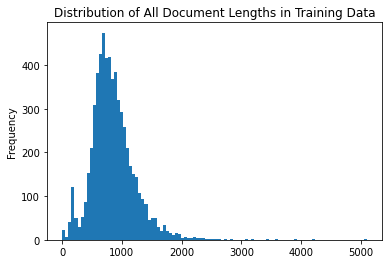

In [4]:
# Most Sentences are between 700 - 1000 characters in length
kiva_df['en_length'] = kiva_df['en_clean'].apply(len)


color = sns.color_palette()
kiva_df['en_length'].plot(title = 'Distribution of All Document Lengths in Training Data' , bins=100, kind='hist')

# Generating views with people that default and not default
default_df = kiva_df[kiva_df['defaulted']==1]
non_default_df = kiva_df[kiva_df['defaulted']==0]

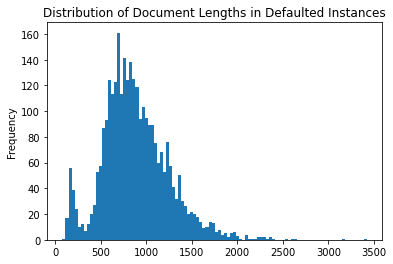

In [5]:
# Default df has a higher spread in document lengths
default_df['en_length'].plot(title = 'Distribution of Document Lengths in Defaulted Instances' ,bins=100, kind='hist')

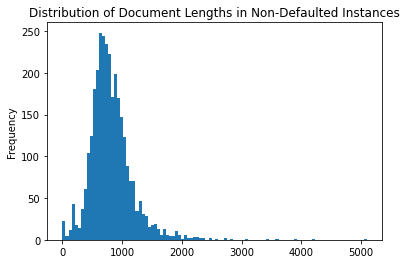

In [6]:
# Non-default has a lower spread in document lengths
non_default_df['en_length'].plot(title = 'Distribution of Document Lengths in Non-Defaulted Instances', bins=100, kind='hist')

In [7]:
# Calculating mean of document lengths for both
mean_def = default_df['en_length'].mean()
mean_non_def = non_default_df['en_length'].mean()
max_def = default_df['en_length'].max()
max_non_def = non_default_df['en_length'].max()
min_def = default_df['en_length'].min()
min_non_def = non_default_df['en_length'].min()
print("The mean document length for default instances: ", mean_def)
print("The mean document length for non-default instances: ", mean_non_def)
print("The max document length for default instances: ", max_def)
print("The max document length for non-default instances: ", max_non_def)
print("The min document length for default instances: ", min_def)
print("The min document length for non-default instances: ", min_non_def)

The mean document length for default instances:  885.0566534914361
The mean document length for non-default instances:  816.607027724049
The max document length for default instances:  3423
The max document length for non-default instances:  5095
The min document length for default instances:  79
The min document length for non-default instances:  2


Text(0.5, 1.0, 'Mean Document Lengths for Default and Non-Default Instances')

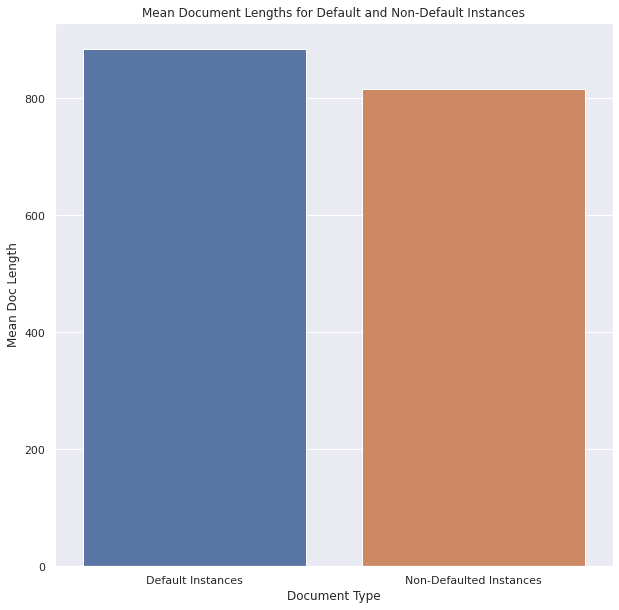

In [8]:
x = [mean_def, mean_non_def]
y = ['Default Instances', 'Non-Defaulted Instances']
sns_df_x = pd.DataFrame(data = x, columns = ['Mean Doc Length'])
sns_df_y = pd.DataFrame(data = y, columns = ['Document Type'])
sns_df = pd.concat([sns_df_x, sns_df_y], axis =1)
sns.set(rc={'figure.figsize':(10,10)})

sns.barplot(x = "Document Type", y = "Mean Doc Length", data = sns_df).set_title('Mean Document Lengths for Default and Non-Default Instances')

Text(0.5, 1.0, 'Minimum Document Lengths for Default and Non-Default Instances')

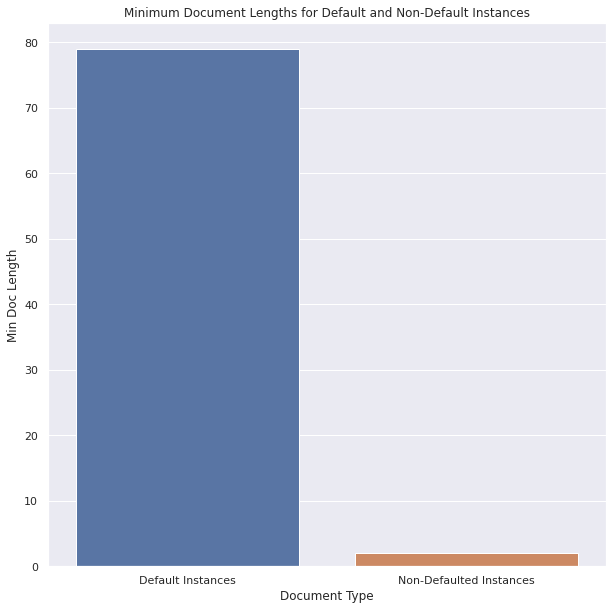

In [9]:
x = [min_def, min_non_def]
y = ['Default Instances', 'Non-Defaulted Instances']
sns_df_x = pd.DataFrame(data = x, columns = ['Min Doc Length'])
sns_df_y = pd.DataFrame(data = y, columns = ['Document Type'])
sns_df = pd.concat([sns_df_x, sns_df_y], axis =1)
sns.set(rc={'figure.figsize':(10,10)})

sns.barplot(x = "Document Type", y = "Min Doc Length", data = sns_df).set_title('Minimum Document Lengths for Default and Non-Default Instances')

Text(0.5, 1.0, 'Maximum Document Lengths for Default and Non-Default Instances')

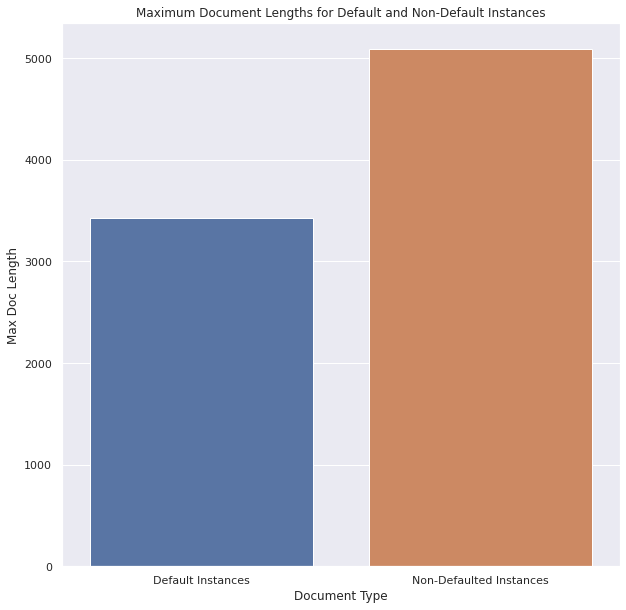

In [10]:
x = [max_def, max_non_def]
y = ['Default Instances', 'Non-Defaulted Instances']
sns_df_x = pd.DataFrame(data = x, columns = ['Max Doc Length'])
sns_df_y = pd.DataFrame(data = y, columns = ['Document Type'])
sns_df = pd.concat([sns_df_x, sns_df_y], axis =1)
sns.set(rc={'figure.figsize':(10,10)})

sns.barplot(x = "Document Type", y = "Max Doc Length", data = sns_df).set_title('Maximum Document Lengths for Default and Non-Default Instances')

### Counting number of symbols (!, $) and words (children), phrases (loan)

In [11]:
def num_exclamation_marks(doc):
    num = doc.count('!')
    return num

def num_dollar_marks(doc):
    num = doc.count('$')
    return num

def num_loan(doc):
    num = doc.lower().count('loan')
    return num

def num_children(doc):
    num = doc.lower().count('children')
    return num

exc_counts_def = default_df['en_clean'].apply(num_exclamation_marks).mean()
exc_counts_nondef = non_default_df['en_clean'].apply(num_exclamation_marks).mean()

dol_counts_def = default_df['en_clean'].apply(num_dollar_marks).mean()
dol_counts_nondef = non_default_df['en_clean'].apply(num_dollar_marks).mean()

l_counts_def = default_df['en_clean'].apply(num_loan).mean()
l_counts_nondef = non_default_df['en_clean'].apply(num_loan).mean()

child_counts_def = default_df['en_clean'].apply(num_children).mean()
child_counts_nondef = non_default_df['en_clean'].apply(num_children).mean()

print(" Mean Exclamation Marks in default instances: ", exc_counts_def)
print(" Mean Exclamation Marks in non-default instances: ", exc_counts_nondef)

print(" Mean Dollar Marks in default instances: ", dol_counts_def)
print(" Mean Dollar Marks in non-default instances: ", dol_counts_nondef)

print(" Mean number of 'Loan' mentions in default instances: ", l_counts_def)
print(" Mean number of 'Loan' mentions in non-default instances: ", l_counts_nondef)

print(" Mean number of 'Children' mentions in default instances: ", child_counts_def)
print(" Mean number of 'Children' mentions in non-default instances: ", child_counts_nondef)

kiva_df['dollar_sign_count'] = kiva_df['en_clean'].apply(num_dollar_marks)
kiva_df['exclamation_count'] = kiva_df['en_clean'].apply(num_exclamation_marks)

 Mean Exclamation Marks in default instances:  0.0016469038208168643
 Mean Exclamation Marks in non-default instances:  0.10735009671179883
 Mean Dollar Marks in default instances:  1.0909090909090908
 Mean Dollar Marks in non-default instances:  0.28497743391360414
 Mean number of 'Loan' mentions in default instances:  1.878787878787879
 Mean number of 'Loan' mentions in non-default instances:  1.5589941972920696
 Mean number of 'Children' mentions in default instances:  1.256258234519104
 Mean number of 'Children' mentions in non-default instances:  1.1463571889103803


In [12]:
print(kiva_df.shape)
print(kiva_df.columns)

(6138, 6)
Index(['loan_id', 'en_clean', 'defaulted', 'en_length', 'dollar_sign_count',
       'exclamation_count'],
      dtype='object')


### Counting number of entities

In [13]:
# Counting the number of 'money' entities using spacy
sp = spacy.load('en_core_web_sm')

def show_ents(doc):
    if doc.ents: 
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + str(ent.label))
    else: 
        print("No entities found")

In [14]:
text = '''Carlo dedicates himself to the distribution of herbs and spices to markets and stores. He started his business with the help of his wife and with a settlement 
he received from a company. In the beginning, he only did wholesale of anise and cumin from his small store, but now he also also sells essences and condiments to markets and stores, 
both wholesale and retail. He will invest the loan into the wholesale purchase of spices, to be able to compete as there is a lot of competition. He is 38 years old and has 3 children; 
one of them works while the others study. His wife is his business partner; his home is made of concrete and his family is stable. He is confident that with this loan, his business will 
grow and the quality of life will improve for his family.
'''

text1 = '''Nancy Wanja Mburu is 50 years old and married with three girls and four boys. One of the girls and all four boys attend school. Nancy is her family's sole breadwinner. 
She has recently been inspired to start supplying onions wholesale to stores instead of her current practise of selling to retailers in the sprawling Gikomba market. At the moment, 
it is difficult for her to support her family fully but she is determined to meet her childrens basic needs and educate them. Therefore, she has requested a loan of US $ 650 to expand
her onion business. She plans to spend the loan in the following way:   US $ 200 to purchase red onion bags  US $ 300 to purchase white onion sack  US $ 150 to pay insurance and 
license'''

text2 = '''
Ester is 65 years old. She is married and has children who are now grown up. Ester is a Christian and a member of the ACK church in Gakoigo. She is also in the Mothers Union group. 
Ester plays a significant role in encouraging the youthful mothers. She gets wary of the fact that the young generation tends to make very hasty decisions, especially in their marriage.
She encourages them to pause, think and pray for any positive changes they wish for their families. She reminds the young married women that patience pays. As the chairlady of Maragwa 
Ushuhuda women group, she goes by Proverbs 31, about the virtuous woman. To earn a living, Ester practices mixed farming. She grows maize, beans and bananas and also keeps dairy cows.
She earns her income from the sale of green bananas, maize and beans. She also sells milk to the area residents. Ester plans to expand the dairy farming so as to increase the milk she
takes to the market. She has applied for a loan of USD 300 to enable her buy a good quality dairy cow. The loans committee has approved her loan which she will repay within a period
of 12 months.
'''

text3 = '''Juana is a wide-awake, funny, and hard-working old woman who lives in the Los Alcarrizos community of Santo Domingo, where she runs a small business. 
Juana retails a variety of underwear and silver jewelry to women of her community. She says that she still feels young in spite of her age (shes 55), and wants to keep doing business
until she achieves her dream, which is to become one of the most well-positioned suppliers of  these goods in her community. Juana is requesting a loan to buy more products and increase 
her stock. The entrepreneur has four children that are finishing secondary school and will start university studies very soon.
'''


doc1 = sp(text1)
show_ents(doc1)

Nancy Wanja Mburu - PERSON - 380
50 years old - DATE - 391
three - CARDINAL - 397
four - CARDINAL - 397
One - CARDINAL - 397
four - CARDINAL - 397
Nancy - PERSON - 380
Gikomba - ORG - 383
US - GPE - 384
650 - MONEY - 394
US - GPE - 384
200 - MONEY - 394
US - GPE - 384
300 - MONEY - 394
US - GPE - 384
150 - MONEY - 394


In [15]:
# Functions for Counting Entities
def money_counts(doc):
    doc1 = sp(doc)
    money_count = len([ent for ent in doc1.ents if ent.label_ == 'MONEY'])
    return money_count

def cardinal_counts(doc):
    doc1 = sp(doc)
    card_count = len([ent for ent in doc1.ents if ent.label_ == 'CARDINAL'])
    return card_count

def gpe_counts(doc):
    doc1 = sp(doc)
    card_count = len([ent for ent in doc1.ents if ent.label_ == 'GPE'])
    return card_count

In [16]:
#Money Entities
default_df['money_ent_count'] = default_df['en_clean'].apply(lambda x: money_counts(x))
non_default_df['money_ent_count'] = non_default_df['en_clean'].apply(lambda x: money_counts(x))
kiva_df['money_ent_count'] = kiva_df['en_clean'].apply(money_counts)

# Calculating mean amount of money entities for both
money_def = default_df['money_ent_count'].mean()
money_non_def = non_default_df['money_ent_count'].mean()
print("The mean amount of money entities in default instances: ", money_def)
print("The mean amount of money entities in non-default instances: ", money_non_def)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The mean amount of money entities in default instances:  1.046772068511199
The mean amount of money entities in non-default instances:  0.2791747259832366


In [17]:
# Cardinal Entities
default_df['cardinal_ent_count'] = default_df['en_clean'].apply(lambda x: cardinal_counts(x))
non_default_df['cardinal_ent_count'] = non_default_df['en_clean'].apply(lambda x: cardinal_counts(x))

# Calculating mean of amount of caridnal entities for both
card_def = default_df['cardinal_ent_count'].mean()
card_non_def = non_default_df['cardinal_ent_count'].mean()
print("The mean amount of cardinal entities in default instances: ", card_def)
print("The mean amount of cardinal entities in non-default instances: ", card_non_def)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The mean amount of cardinal entities in default instances:  2.0596179183135703
The mean amount of cardinal entities in non-default instances:  1.8359123146357188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# GPE Entities
default_df['gpe_ent_count'] = default_df['en_clean'].apply(gpe_counts)
non_default_df['gpe_ent_count'] = non_default_df['en_clean'].apply(gpe_counts)

# # Calculating mean of document lengths for both
gpe_def = default_df['gpe_ent_count'].mean()
gpe_non_def = non_default_df['gpe_ent_count'].mean()
print("The mean amount of gpe entities in default instances: ", gpe_def)
print("The mean amount of gpe entities in non-default instances: ", gpe_non_def)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The mean amount of gpe entities in default instances:  1.3191699604743083
The mean amount of gpe entities in non-default instances:  1.056415215989684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
clean_kiva_df = kiva_df

In [20]:
#kiva_df = clean_kiva_df
print(kiva_df.columns)
print(kiva_df.shape)

Index(['loan_id', 'en_clean', 'defaulted', 'en_length', 'dollar_sign_count',
       'exclamation_count', 'money_ent_count'],
      dtype='object')
(6138, 7)


# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

X = kiva_df[['en_clean','en_length', 'dollar_sign_count', 'exclamation_count', 'money_ent_count']]
y = kiva_df['defaulted']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=20)

In [22]:
print(X_train.shape)
print(X_train.columns)

(5217, 5)
Index(['en_clean', 'en_length', 'dollar_sign_count', 'exclamation_count',
       'money_ent_count'],
      dtype='object')


### TF-IDF

In [23]:
import unidecode
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

lemmer = WordNetLemmatizer()

def preprocess(x):
    # Lower case
    x = x.lower()
    
    # Remove punctuation
    x = re.sub(r'[^\w\s]', '', x)

    # Remove numbers
    x = re.sub(r'\d+', '', x)
    
    # Remove non-unicode
    x = unidecode.unidecode(x)
        
    # Remove stopwords and lemmatize
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    return ' '.join(x) 

X_train['en_clean_pre'] = X_train['en_clean'].apply(preprocess)
X_val['en_clean_pre'] = X_val['en_clean'].apply(preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
print(X_train.shape)
print(X_train.columns)

(5217, 6)
Index(['en_clean', 'en_length', 'dollar_sign_count', 'exclamation_count',
       'money_ent_count', 'en_clean_pre'],
      dtype='object')


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.04, max_features=1000, ngram_range=[1,3])
vectorizer = TfidfVectorizer(max_features = 1000, max_df=0.5, min_df=0.04, use_idf=True)

#Fit Transform on X_train
dtm = vectorizer.fit_transform(X_train['en_clean_pre'])

#Transform on X_val
dtm_2 = vectorizer.transform(X_val['en_clean_pre'])

print(dtm.shape)
print(vectorizer.get_feature_names())
print(X_train.shape)


(5217, 291)
['able', 'active', 'activity', 'add', 'additional', 'age', 'ago', 'allow', 'already', 'also', 'always', 'amount', 'another', 'applied', 'area', 'attend', 'back', 'basic', 'basis', 'bean', 'beauty', 'become', 'began', 'belief', 'better', 'born', 'bought', 'boy', 'build', 'bulk', 'buy', 'buying', 'capital', 'care', 'cement', 'challenge', 'chicken', 'childrens', 'church', 'city', 'client', 'clientele', 'clothes', 'clothing', 'college', 'come', 'community', 'company', 'condition', 'continue', 'cost', 'could', 'cow', 'credit', 'currently', 'customer', 'daily', 'dairy', 'daughter', 'day', 'decided', 'demand', 'different', 'domingo', 'dominican', 'dream', 'due', 'earn', 'earns', 'educate', 'education', 'enable', 'enough', 'entrepreneur', 'every', 'expand', 'expense', 'experience', 'explains', 'family', 'farm', 'farmer', 'farming', 'father', 'fee', 'feed', 'first', 'five', 'food', 'four', 'friend', 'fruit', 'fund', 'future', 'get', 'girl', 'give', 'given', 'go', 'goal', 'good', 'go

In [26]:
bow_df = pd.DataFrame(dtm.toarray(), columns = vectorizer.get_feature_names())
bow_2_df = pd.DataFrame(dtm_2.toarray(), columns = vectorizer.get_feature_names())

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)


X_train_tfidf = pd.concat([X_train,bow_df], axis = 1)
X_val_tfidf = pd.concat([X_val,bow_2_df], axis = 1)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(5217, 297)
(921, 297)


### Adding Topics

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=20, doc_topic_prior=None,
                                      topic_word_prior=None, max_iter=1000, 
                                      learning_method='batch', random_state=20,
                                      n_jobs=10,verbose=0)

lda_output = lda_model.fit(dtm)

# Log Likelyhood: Higher the better
ll = lda_model.score(dtm)

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
perp = lda_model.perplexity(dtm)

In [28]:
topic_doc_mat = pd.DataFrame(lda_model.transform(dtm))
topic_doc_mat_val =  pd.DataFrame(lda_model.transform(dtm_2))

X_train_tfidf.reset_index(drop=True, inplace=True)
X_val_tfidf.reset_index(drop=True, inplace=True)


X_train_latest = pd.concat([X_train_tfidf,topic_doc_mat], axis = 1)
X_val_latest = pd.concat([X_val_tfidf,topic_doc_mat_val], axis = 1)

print(X_train_latest.shape)
print(X_val_latest.shape)


(5217, 317)
(921, 317)


# Dropping columns

In [29]:
X_train_latest = X_train_latest.drop(columns = ['en_clean', 'en_clean_pre'])

X_val_latest = X_val_latest.drop(columns = ['en_clean', 'en_clean_pre'])

print(X_train_latest.shape)
print(X_val_latest.shape)

(5217, 315)
(921, 315)


# Model Creation

In [31]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train_latest)
X_val_std = scaler.transform(X_val_latest)


print("\n\n Random Forest")
rf_clf = RandomForestClassifier(n_estimators=1000, criterion = 'gini', max_depth=25, random_state=0);
%time rf_clf.fit(X_train_latest, y_train)
y_preds = rf_clf.predict(X_val_latest)
print("\n\n\n",classification_report(y_val, y_preds))

print("\n\n Logistic Regression")
lr_clf = LogisticRegression(C= 1.0, max_iter= 1000, random_state=0);
%time lr_clf.fit(X_train_std, y_train)
y_preds = lr_clf.predict(X_val_std)
print("\n\n\n",classification_report(y_val, y_preds))

print("\n\n SVM ")
svm_clf = SVC(C= 5, kernel='rbf', degree = 3, random_state=20);
%time svm_clf.fit(X_train_std, y_train)
y_preds = svm_clf.predict(X_val_std)
print("\n\n\n",classification_report(y_val, y_preds))

print("\n\n Adaboost")
ada_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.4, random_state=0)
%time ada_clf.fit(X_train_latest, y_train)
y_preds = ada_clf.predict(X_val_latest)
print("\n\n\n",classification_report(y_val, y_preds))
    
print("\n\n GTB")
gtb_clf = GradientBoostingClassifier(n_estimators=900, learning_rate=0.4, max_depth=25, random_state=0)
%time gtb_clf.fit(X_train_latest, y_train)
y_preds = gtb_clf.predict(X_val_latest)
print("\n\n\n",classification_report(y_val, y_preds))

print("\n\n Naive Bayes")
gnb_clf = GaussianNB()
%time gnb_clf.fit(X_train_latest, y_train)
y_preds = gnb_clf.predict(X_val_latest)
print("\n\n\n",classification_report(y_val, y_preds))




 Random Forest
CPU times: user 25.4 s, sys: 41.2 ms, total: 25.4 s
Wall time: 25.4 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)




               precision    recall  f1-score   support

           0       0.80      0.87      0.83       434
           1       0.88      0.80      0.84       487

    accuracy                           0.84       921
   macro avg       0.84      0.84      0.84       921
weighted avg       0.84      0.84      0.84       921



 Logistic Regression
CPU times: user 339 ms, sys: 345 ms, total: 684 ms
Wall time: 186 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)




               precision    recall  f1-score   support

           0       0.82      0.84      0.83       434
           1       0.85      0.84      0.84       487

    accuracy                           0.84       921
   macro avg       0.84      0.84      0.84       921
weighted avg       0.84      0.84      0.84       921



 SVM 
CPU times: user 13.4 s, sys: 366 ms, total: 13.8 s
Wall time: 13.4 s


SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=20, shrinking=True, tol=0.001,
    verbose=False)




               precision    recall  f1-score   support

           0       0.84      0.88      0.86       434
           1       0.89      0.85      0.87       487

    accuracy                           0.87       921
   macro avg       0.87      0.87      0.87       921
weighted avg       0.87      0.87      0.87       921



 Adaboost
CPU times: user 5.3 s, sys: 28.7 ms, total: 5.33 s
Wall time: 5.31 s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.4,
                   n_estimators=100, random_state=0)




               precision    recall  f1-score   support

           0       0.78      0.82      0.80       434
           1       0.84      0.80      0.82       487

    accuracy                           0.81       921
   macro avg       0.81      0.81      0.81       921
weighted avg       0.81      0.81      0.81       921



 GTB
CPU times: user 28.2 s, sys: 17.8 ms, total: 28.3 s
Wall time: 28.2 s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=25,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=900,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)




               precision    recall  f1-score   support

           0       0.82      0.85      0.83       434
           1       0.86      0.83      0.85       487

    accuracy                           0.84       921
   macro avg       0.84      0.84      0.84       921
weighted avg       0.84      0.84      0.84       921



 Naive Bayes
CPU times: user 32.5 ms, sys: 2 ms, total: 34.5 ms
Wall time: 33.5 ms


GaussianNB(priors=None, var_smoothing=1e-09)




               precision    recall  f1-score   support

           0       0.70      0.81      0.75       434
           1       0.80      0.69      0.74       487

    accuracy                           0.74       921
   macro avg       0.75      0.75      0.74       921
weighted avg       0.75      0.74      0.74       921



In [32]:
imp = pd.DataFrame(rf_clf.feature_importances_, index = X_train_latest.columns, columns=['importance']).sort_values('importance', ascending=False).iloc[0:15,:]
print(imp)

                   importance
7                    0.045089
14                   0.032344
dollar_sign_count    0.024316
money_ent_count      0.023249
repay                0.020856
9                    0.016164
16                   0.015302
10                   0.014625
18                   0.014152
11                   0.013905
en_length            0.013534
8                    0.013433
requesting           0.012802
usd                  0.011505
married              0.011292


# Model Training/Tuning/Cross Validation


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['rbf'],
    'C': [5,10,15],
     'gamma' : [0.1, 0.01, 0.02]
}


search = GridSearchCV(svm_clf, 
                      param_grid, 
                      cv=3, 
                      n_jobs=1, 
                      scoring='f1_macro', 
                      return_train_score=True, 
                      verbose=2)

%time search = search.fit(X_train_std, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=5, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=5, gamma=0.1, kernel=rbf, total=   5.6s
[CV] C=5, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ....................... C=5, gamma=0.1, kernel=rbf, total=   5.7s
[CV] C=5, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=5, gamma=0.1, kernel=rbf, total=   5.6s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   5.5s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   5.6s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   5.3s
[CV] C=5, gamma=0.02, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.02, kernel=rbf, total=   5.2s
[CV] C=5, gamma=0.02, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.02, kernel=rbf, total=   5.3s
[CV] C=5, gamma=0.02, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.9min finished


CPU times: user 4min 5s, sys: 191 ms, total: 4min 5s
Wall time: 4min 4s


In [35]:
# Print out the results of hyperparmater tuning

def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    results['mean_fit_time'] = cv_results['mean_fit_time']
    results['mean_score_time'] = cv_results['mean_score_time']
    results['mean_train_score'] = cv_results['mean_train_score']
    results['std_train_score'] = cv_results['std_train_score']
    results['mean_test_score'] = cv_results['mean_test_score']
    results['std_test_score'] = cv_results['std_test_score']
    results['rank_test_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_test_score'], ascending=False)
    return results

results = cv_results_to_df(search.cv_results_)
results

,C,gamma,kernel,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,5,0.10,rbf,3.948375,1.670723,0.979188,0.001418,0.848028,0.009308,1
3,10,0.10,rbf,5.403006,1.737601,0.995301,0.000755,0.844762,0.010017,2
6,15,0.10,rbf,5.533059,1.755390,0.997315,0.000489,0.843842,0.010887,3
8,15,0.02,rbf,3.457500,1.398416,0.891053,0.004127,0.828357,0.006420,4
5,10,0.02,rbf,3.459194,1.442704,0.878882,0.003966,0.824714,0.010030,5
2,5,0.02,rbf,3.658349,1.531957,0.859962,0.003680,0.822739,0.008044,6
7,15,0.01,rbf,3.466067,1.454566,0.862102,0.003433,0.820866,0.009508,7
4,10,0.01,rbf,3.542212,1.505417,0.852786,0.002489,0.819116,0.009024,8
1,5,0.01,rbf,3.831740,1.624606,0.836741,0.002594,0.813141,0.011316,9


# Hyper Tuned Model Assessment

In [36]:
y_val_pred = search.predict(X_val_std)

In [39]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))

class_names = [str(x) for x in search.best_estimator_.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

[[384  50]
 [ 69 418]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       434
           1       0.89      0.86      0.88       487

    accuracy                           0.87       921
   macro avg       0.87      0.87      0.87       921
weighted avg       0.87      0.87      0.87       921

